## Preliminary analysis of Amazon stock messages data.


#### Date and timespan: 21-06-21 between 9:30 and 16:00.

In [197]:
# Importing libraries
import numpy as np
import matplotlib.pyplot as plt
company = 'INTC'
path = 'results/inspect_message/'+company+'/'

In [198]:
# Loading messagedata from csv file
data = np.loadtxt('LOBSTER_Data/LOBSTER_SampleFile_'+company+'_2012-06-21_10/'+company+'_2012-06-21_34200000_57600000_message_10.csv',delimiter=',')
# Loading LOB data
lob_data = np.loadtxt('LOBSTER_Data/LOBSTER_SampleFile_'+company+'_2012-06-21_10/'+company+'_2012-06-21_34200000_57600000_orderbook_10.csv',delimiter=',')

In [199]:
# Check shape of the data
data.shape

(624040, 6)

In [200]:
# Inspect first row
data[0,:]

array([ 3.42000057e+04,  4.00000000e+00,  1.58350120e+07,  3.40000000e+01,
        2.75200000e+05, -1.00000000e+00])

In [201]:
# Split data into columns
time = (data[:,0]*10**9).astype(np.int64) # Time of message
order_types = (data[:,1]).astype(int) # Order type
order_ids = (data[:,2]).astype(int) # Order ID
volumes = (data[:,3]).astype(int) # Volume
prices = (data[:,4]).astype(int) # Price
directions = (data[:,5]).astype(int) # Direction

#### Repeating info from the README file

	Columns:

		1.) Time: 		
				Seconds after midnight with decimal 
				precision of at least milliseconds 
				and up to nanoseconds depending on 
				the requested period
		2.) Type:
				1: Submission of a new limit order
				2: Cancellation (Partial deletion 
					of a limit order)
				3: Deletion (Total deletion of a limit order)
				4: Execution of a visible limit order			   	 
				5: Execution of a hidden limit order
				7: Trading halt indicator 				   
					(Detailed information below)
		3.) Order ID: 	
				Unique order reference number 
				(Assigned in order flow)
		4.) Size: 		
				Number of shares
		5.) Price: 		
				Dollar price times 10000 
				(i.e., A stock price of $91.14 is given 
				by 911400)
		6.) Direction:
				-1: Sell limit order
				1: Buy limit order
				
				Note: 
				Execution of a sell (buy) limit
				order corresponds to a buyer (seller) 
				initiated trade, i.e. Buy (Sell) trade.

We want to compute number of MOs. However, a single MO might correspond to many messages. Single MO can be however distinguished by same time, same order type (execution) and same direction. We use all conditions.

In [202]:
# Compute the number of market orders and other order types in the data
MOs = []
no_messages_of_type = [0,0,0,0,0,0,0]
# Iterate over messages
for i in range(0, time.shape[0]):
    # Increment message type
    no_messages_of_type[order_types[i]-1]+=1
    # If market order
    if order_types[i] in [4,5]:
        # If list of market orders is not empty
        if len(MOs)>0:
            # If the time of execution is the same as the previous MO
            if time[i] == MOs[-1][0]:
                if directions[i]==MOs[-1][2]: # Part of the same order
                    # Increment the volume of previous MO
                    ob = (time[i], MOs[-1][1]+volumes[i], directions[i])
                    MOs[-1] = ob
                    continue
        # Otherwise append new MO to the list (time of MO, volume and direction)
        MOs.append((time[i], volumes[i], directions[i]))



Number of market orders and number of messages split into different order types.

In [203]:
# Number statistics of types of orders
print('MOS', len(MOs))
print('MO messages', no_messages_of_type[4-1])
print('LO creations', no_messages_of_type[1-1])
print('LO (partial) cancellations', no_messages_of_type[2-1])
print('LO deletions', no_messages_of_type[3-1])
# count = 0
# for i in range(len(no_messages_of_type)):
#     count+=no_messages_of_type[i]
# print(count)

MOS 10370
MO messages 28924
LO creations 304790
LO (partial) cancellations 8028
LO deletions 278739


Market Order frequency (day average).

In [204]:
# Calculating market order frequency
mo_f = len(MOs)/(7.5*3600) # Dividing number of MOs by total number of seconds in the trading day
print(f'Market order frequency: {mo_f} orders per second')


Market order frequency: 0.38407407407407407 orders per second


Market Order frequency throughout the day calculated as number of MOs in 30 minute windows.

In [205]:
# Calculating market order frequency fluctuations based on number of orders in a 30 minute window
base_time = 34200000000000 # Starting time
time_increments = 30*60*10**9 # Time increments
final_time = 57600000000000 # Final time

no_MOs = []
it=0
times = []
# Iterating over 30 minute windows in the day
for i in range(base_time+time_increments,final_time+1, time_increments):
    mos_number = 0
    # While MOs time fits the window increment number of MOs
    while it<len(MOs) and MOs[it][0]<i:
        mos_number+=1
        it+=1
    no_MOs.append(mos_number)
    times.append(i//10**9)

print(no_MOs) # Number of MOs per each window
print(times) # Ending time of each window in seconds



[1702, 639, 437, 666, 758, 618, 564, 410, 537, 347, 572, 914, 2206]
[36000, 37800, 39600, 41400, 43200, 45000, 46800, 48600, 50400, 52200, 54000, 55800, 57600]


In [206]:
# Defining helper function for printing time from seconds
def convert(seconds):
    seconds = seconds % (24 * 3600)
    hour = seconds // 3600
    seconds %= 3600
    minutes = seconds // 60
    seconds %= 60
     
    return "%d:%02d" % (hour, minutes)
# for t in times:
#     print(convert(t))


Bar plot of the number of Market Orders per 30 minute windows.

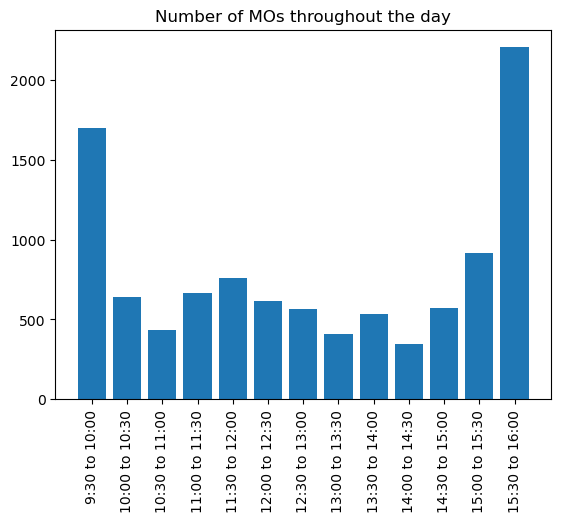

In [207]:
# Plotting the number of orders in each half hour of the day
base_times = [34200]
base_times.extend(times)
hour_times = [convert(base_times[i]) +' to ' + convert(base_times[i+1]) for i in range(len(times))]
plt.bar(list(range(0,13)),no_MOs)
plt.xticks(list(range(0,13)), hour_times, rotation=90)
plt.title('Number of MOs throughout the day')
plt.savefig(path+'MOs_throughout_day.png')
plt.show()

Distribution of Market Order volumes.

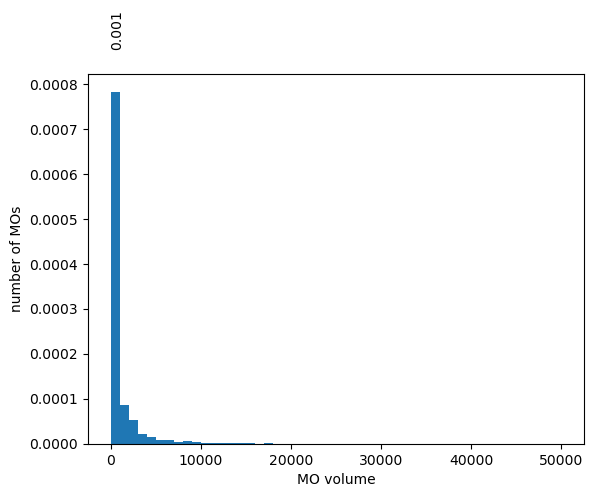

Mean MO volume: 1009.8018322082931


In [208]:
# Plotting distribution of market order volumes
mo_volumes = []
for mo in MOs:
    mo_volumes.append(mo[1])
n, bins, patches = plt.hist(mo_volumes, bins=50, density=True)
for i in range(len(n)):
    if float('%.3f' % n[i])>0:
        plt.text(bins[i], n[i]+0.0001, '%.3f' % n[i],rotation=90)
plt.xlabel('MO volume')
plt.ylabel('number of MOs')
plt.savefig(path+'MOs_volumes_distribution.png')
plt.show()

print(f'Mean MO volume: {np.mean(mo_volumes)}')

Number of MOs split by directions.

In [209]:
# Checking imbalance on buy sell MO side
buy_MOs = []
sell_MOs = []
for mo in MOs:
    if mo[2]==-1:
        buy_MOs.append(mo)
    else:
        sell_MOs.append(mo)

print(f'Number of buy MOs: {len(buy_MOs)}')
print(f'Number of sell MOs: {len(sell_MOs)}')

Number of buy MOs: 4291
Number of sell MOs: 6079


Cumulative volume traded per time and mean volume in 15 minute windows throughout the day.

In [210]:
# Calculating cumulative volume per day of trading and average volume throughout the day based on 15 minute average
base_time = 34200000000000 # Starting time
time_increments = 15*60*10**9 # Time increments
final_time = 57600000000000 # Final time

cumulative_volume = [0]
mean_volume = []
it=0
times = [base_time//10**9]
# Iterate over 30 minute windows
for i in range(base_time+time_increments,final_time+1, time_increments):
    tmp_volumes = []
    # Increase total volume traded in the window while MOs fit window
    while it<len(MOs) and MOs[it][0]<i:
        tmp_volumes.append(MOs[it][1])
        it+=1
    # Add the total to cumulative volume
    cumulative_volume.append(np.sum(tmp_volumes)+cumulative_volume[-1])
    # Calculate 30 minute mean
    mean_volume.append(np.sum(tmp_volumes)/15)
    times.append(i//10**9)

print(times) # Window ending times
print(mean_volume) # Average volumes per time (volume per minute)
print(cumulative_volume) # Cumulative volumes


[34200, 35100, 36000, 36900, 37800, 38700, 39600, 40500, 41400, 42300, 43200, 44100, 45000, 45900, 46800, 47700, 48600, 49500, 50400, 51300, 52200, 53100, 54000, 54900, 55800, 56700, 57600]
[44408.333333333336, 27944.133333333335, 28228.4, 19336.0, 13909.866666666667, 13072.2, 21208.733333333334, 19728.066666666666, 22571.2, 22366.133333333335, 12753.0, 33805.53333333333, 18352.266666666666, 19299.4, 16922.4, 18017.666666666668, 31108.733333333334, 20326.4, 11309.866666666667, 8527.333333333334, 12205.333333333334, 23999.866666666665, 21106.933333333334, 39539.066666666666, 52170.46666666667, 125892.33333333333]
[0, 666125, 1085287, 1508713, 1798753, 2007401, 2203484, 2521615, 2817536, 3156104, 3491596, 3682891, 4189974, 4465258, 4754749, 5008585, 5278850, 5745481, 6050377, 6220025, 6347935, 6531015, 6891013, 7207617, 7800703, 8583260, 10471645]


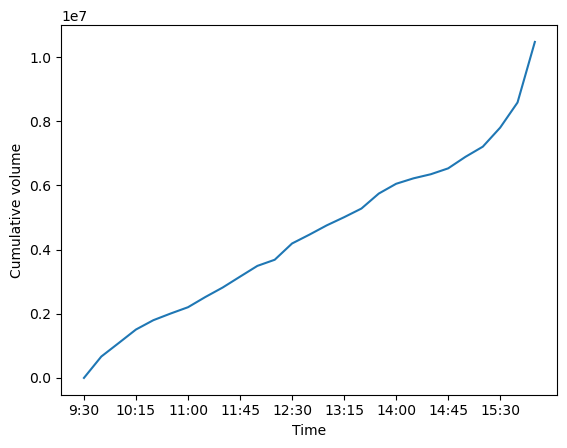

In [211]:
# Plotting cumulative volume
fig, ax = plt.subplots(1,1)
ax.plot(times, cumulative_volume)
ax.set_xticks(times[::3])
ax.xaxis.set_major_formatter(lambda x, pos: convert(x))
ax.set_xlabel('Time')
ax.set_ylabel('Cumulative volume')
plt.savefig(path+'cumulative_volume.png')

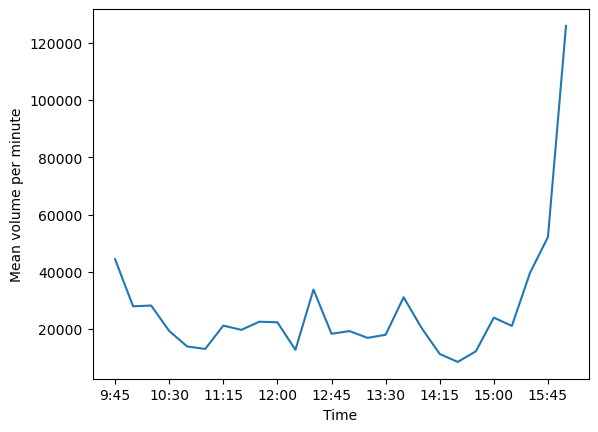

In [212]:
# Plotting mean volume
fig, ax = plt.subplots(1,1)
ax.plot(times[1:], mean_volume)
ax.set_xticks(times[1::3])
ax.xaxis.set_major_formatter(lambda x, pos: convert(x))
ax.set_xlabel('Time')
ax.set_ylabel('Mean volume per minute')
plt.savefig(path+'mean_volume.png')

#### Compiling limit order info

In [213]:
# Getting limit order data to extract midprices
# Splitting order data into levels and volumes
lob_levels = (lob_data[:,0::2]).astype(int)
lob_volumes = (lob_data[:,1::2]).astype(int)
# Splitting data into bid and ask
lob_ask_levels = lob_levels[:,0::2]
lob_bid_levels = lob_levels[:,1::2]

lob_ask_volumes = lob_volumes[:,0::2]
lob_bid_volumes = lob_volumes[:,1::2]

# Calculating mid prices
lob_mid_prices = (lob_ask_levels[:,0] + lob_bid_levels[:,0])/2

In [214]:
# Compiling limit order info
LO_dict = dict() # dictinary for holding Limit Orders
# price: [(order_type, volume, price, mid_price_at_post, distance_from_midprice/100, direction, best_bid_at_post, best_ask_at_post]

# Iterate over messages
for i in range(0, time.shape[0]):
    if order_ids[i] not in LO_dict.keys() and order_types[i]==1:
        LO_dict[order_ids[i]] = [(order_types[i], volumes[i], prices[i], lob_mid_prices[i-1], np.abs(prices[i]-lob_mid_prices[i-1])/100,
         directions[i], lob_bid_levels[i-1,0],lob_ask_levels[i-1,0])]
    # If order already in dict append tuple with order modification (execution, deletion, cancellation)
    elif order_ids[i] in LO_dict.keys():
        LO_dict[order_ids[i]].append((order_types[i], volumes[i]))

# Show some output
lo_order_ids = list(LO_dict.keys())
print(lo_order_ids[:10])
print(lo_order_ids[3])
print(LO_dict[lo_order_ids[3]]) 
print(len(order_ids))
print(len(LO_dict))
# Order has initial type 1 (should always have), volume 13,
# price 2240000, midprice at post 2238800, distance from midprice 12,
# best bid at post is 2238100, best ask at post is 2239500.
# Order is then executed (MO) fully.

[16114545, 16114695, 16114707, 16127246, 16127264, 16127293, 16127306, 16127319, 16127343, 16127361]
16127246
[(1, 100, 275000, 275150.0, 1.5, 1, 275100, 275200), (4, 100)]
624040
304790


Distribution of Limit Orders at post. This corresponds to probability of putting LO at position given current midprice.

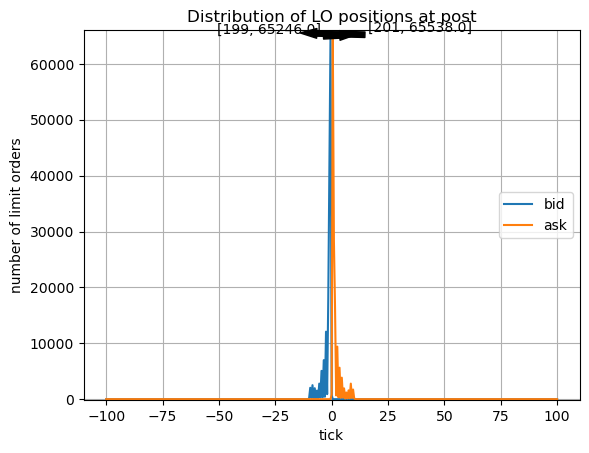

In [215]:
# Plotting distribution of Limit Order positions at post
ticks = np.linspace(-100,100,401) # Tick (position) array
# Initializing array to hold number of LOs at positions
num_bid_orders_at_tick = ticks*0 
num_ask_orders_at_tick = ticks*0
# Iterate over Limit Orders
for lo_order_id in lo_order_ids:
    # Retrieve LO from dictionary
    lo = LO_dict[lo_order_id]
    # Get distance
    distance = (lo[0][2]-lo[0][3])/100
    if np.abs(distance) != lo[0][4]:
        print(lo_order_id)
    # distance = lo[0][4]
    # If abs distance is smaller than 100
    if np.abs(distance)<=100:
        # If direction is bid
        if lo[0][5]==1:
            # Increment number of bid orders at position
            num_bid_orders_at_tick[int(distance*2)+200]+=1
        # If direction is ask
        else:
            # Increment number of ask orders at position
            num_ask_orders_at_tick[int(distance*2)+200]+=1

# Plot
plt.plot(ticks, num_bid_orders_at_tick, label='bid')
bid_max = np.argmax(num_bid_orders_at_tick)
show_bid_max = '['+str(bid_max)+', '+str(num_bid_orders_at_tick[bid_max])+']'
plt.annotate(show_bid_max,xy=(bid_max-188,num_bid_orders_at_tick[bid_max]),xytext=(bid_max-250,num_bid_orders_at_tick[bid_max]+200),xycoords='data',arrowprops=dict(facecolor='black', headwidth=7))
plt.plot(ticks, num_ask_orders_at_tick, label='ask')
ask_max = np.argmax(num_ask_orders_at_tick)
show_ask_max = '['+str(ask_max)+', '+str(num_ask_orders_at_tick[ask_max])+']'
plt.annotate(show_ask_max,xy=(ask_max-215,num_ask_orders_at_tick[ask_max]),xytext=(ask_max-185,num_ask_orders_at_tick[ask_max]+200),xycoords='data',arrowprops=dict(facecolor='black', headwidth=7))
plt.ylim((-100, max(num_bid_orders_at_tick[bid_max], num_ask_orders_at_tick[ask_max])+500))
plt.xlabel('tick')
plt.ylabel('number of limit orders')
plt.legend(loc='center right')
plt.title('Distribution of LO positions at post')
plt.grid()
plt.savefig(path+'LO_positions_at_post_distribution.png')

Execution probability. The probability that limit order was filled as a function of distance to midprice at post.

In [216]:
# Calculating execution ratio for each LO
# Iterate over Limit Orders
for lo_id in lo_order_ids:
    lo = LO_dict[lo_id]
    # Initionalize number of filled (executed) volume in the LO
    executed = 0
    # Iterate over modifications of LO (consecutive entries in the LO list)
    for i in range(1,len(lo)):
        if lo[i][0]==4: # Modification corresponds to execution
            executed+=lo[i][1]
    fill_ratio = executed/lo[0][1] 
    # Append ratio of execution to Limit Order list (run once!!! per LO_dict initialization)
    lo.append(fill_ratio)

In [217]:
# Inspect some output
print(LO_dict[lo_order_ids[2]]) # Partially executed and then deleted
print(LO_dict[lo_order_ids[110]]) # Deleted

[(1, 100, 275800, 275150.0, 6.5, -1, 275100, 275200), (3, 100), 0.0]
[(1, 1000, 274600, 275200.0, 6.0, 1, 275100, 275300), (2, 500), (3, 500), 0.0]


The probability of filling LO can be either non-weighted - then for a given position the value of probability is an average of all corresponding LO fill ratios. If weighted, the fill ratios are weighted by the volume of Limit Order.

In [218]:
# Calculating probability per distance from midprice
ticks = np.linspace(0, 100, 201)

# Non-weighted by volume
probabilities = np.zeros(shape=(201,))
fill_ratio_sums = np.zeros(shape=(201,))
num_orders_on_tick = np.zeros(shape=(201,))

# Iterate over LOs
for lo_id in lo_order_ids:
    # Get LO
    lo = LO_dict[lo_id]
    # Get distance
    distance = lo[0][4]
    # If distance is smaller than 100
    if distance<=100:
        # Get index for result arrays
        index = int(distance*2)
        # Increment number of orders at position
        num_orders_on_tick[index]+=1
        # Increase fill ratio sum
        fill_ratio_sums[index]+=lo[-1]
# Calculate probabilities as averages of fill ratios
for i in range(201):
    if num_orders_on_tick[i]>0:
        probabilities[i] = fill_ratio_sums[i]/num_orders_on_tick[i]

# Weighted by volume
weighted_probabilities = np.zeros(shape=(201,))
weighted_fill_ratio_sums = np.zeros(shape=(201,))
volume_on_tick = np.zeros(shape=(201,))

# Iterate over LOs
for lo_id in lo_order_ids:
    # Get LO
    lo = LO_dict[lo_id]
    # Get distance
    distance = lo[0][4]
    # If distance is smaller than 100
    if distance<=100:
        # Get index for result arrays
        index = int(distance*2)
        # Increase total volume at position
        volume_on_tick[index]+=lo[0][1]
        # Increase fill ratio sum
        weighted_fill_ratio_sums[index]+=lo[-1]*lo[0][1]
# Calculate probabilities as averages of fill ratios
for i in range(201):
    if volume_on_tick[i]>0:
        weighted_probabilities[i] = weighted_fill_ratio_sums[i]/volume_on_tick[i]

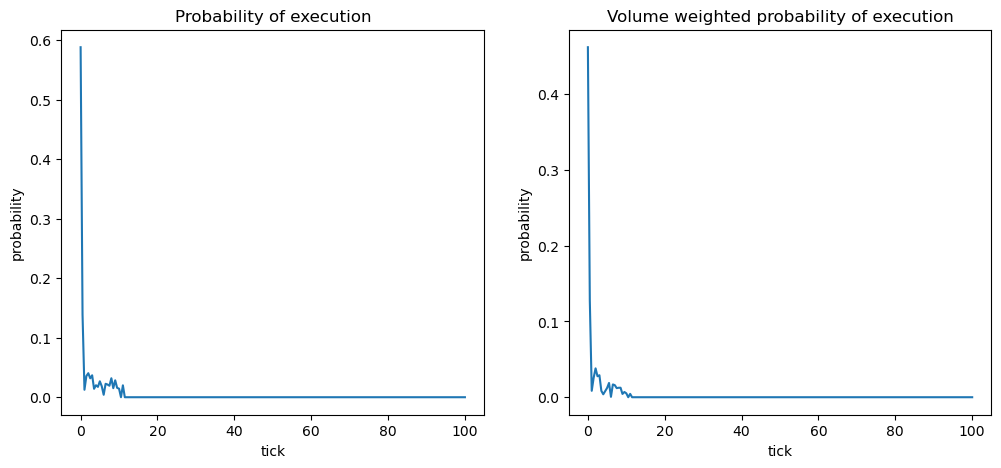

In [219]:
# Plotting
fig, axs = plt.subplots(1,2, figsize=(12,5))
axs[0].plot(ticks, probabilities)
axs[0].set_xlabel('tick')
axs[0].set_ylabel('probability')
axs[0].set_title('Probability of execution')
axs[1].plot(ticks, weighted_probabilities)
axs[1].set_xlabel('tick')
axs[1].set_ylabel('probability')
axs[1].set_title('Volume weighted probability of execution')
plt.savefig(path+'probability_per_distance_from_midprice.png')



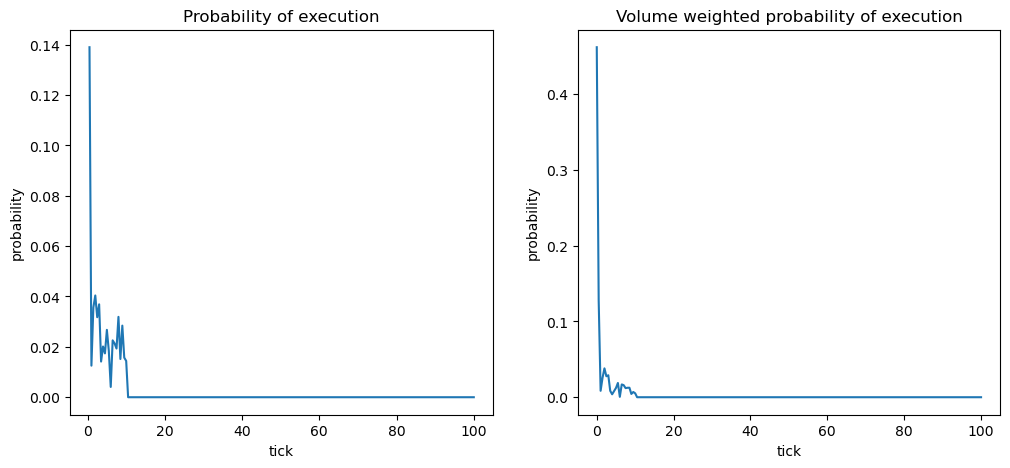

In [220]:
# Cleaning probabilities from outliers (not including positions with less than 200 filed orders) and plotting again
from copy import deepcopy


cleaned_probabilities = deepcopy(probabilities)
cleaned_weighted_probabilities = deepcopy(weighted_probabilities)

for i in range(201):
    if num_orders_on_tick[i]<200:
        cleaned_probabilities[i] = 0
        cleaned_weighted_probabilities[i] = 0

fig, axs = plt.subplots(1,2, figsize=(12,5))
axs[0].plot(ticks[1:], cleaned_probabilities[1:])
axs[0].set_xlabel('tick')
axs[0].set_ylabel('probability')
axs[0].set_title('Probability of execution')
axs[1].plot(ticks, cleaned_weighted_probabilities)
axs[1].set_xlabel('tick')
axs[1].set_ylabel('probability')
axs[1].set_title('Volume weighted probability of execution')
plt.savefig(path+'probability_cleaned_per_distance_from_outliers.png')

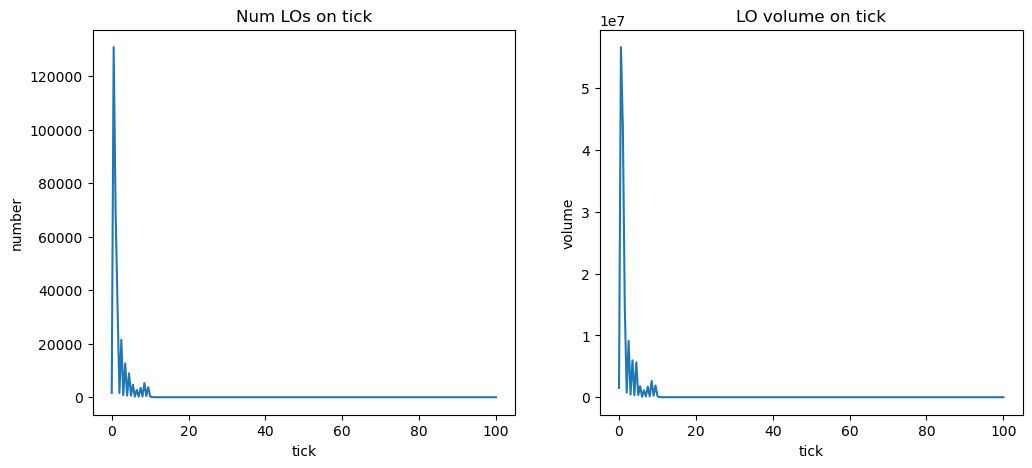

In [221]:
# Plotting distribution of total number of LOs and total LO volumes per tick

fig, axs = plt.subplots(1,2, figsize=(12,5))
axs[0].plot(ticks, num_orders_on_tick)
axs[0].set_xlabel('tick')
axs[0].set_ylabel('number')
axs[0].set_title('Num LOs on tick')
axs[1].plot(ticks, volume_on_tick)
axs[1].set_xlabel('tick')
axs[1].set_ylabel('volume')
axs[1].set_title('LO volume on tick')
plt.savefig(path+'distribution_per_tick.png')


Splitting above analysis by directions.

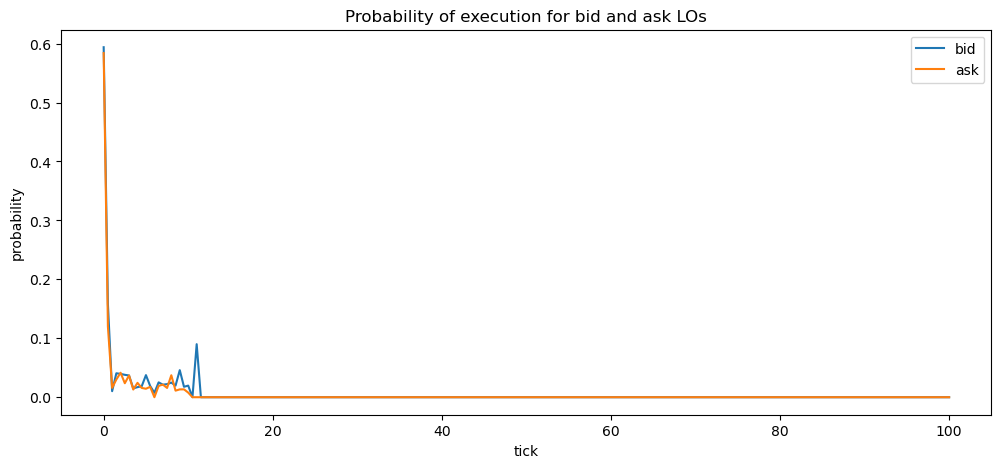

In [222]:
# Calculating probability per distance from midprice for bid LOs and ask LOs
ticks = np.linspace(0, 100, 201)

# Non-weighted by volume
bid_probabilities = np.zeros(shape=(201,))
bid_fill_ratio_sums = np.zeros(shape=(201,))
bid_num_orders_on_tick = np.zeros(shape=(201,))
ask_probabilities = np.zeros(shape=(201,))
ask_fill_ratio_sums = np.zeros(shape=(201,))
ask_num_orders_on_tick = np.zeros(shape=(201,))

for lo_id in lo_order_ids:
    lo = LO_dict[lo_id]
    distance = lo[0][4]
    if distance<=100:
        index = int(distance*2)
        if lo[0][5]==1:
            bid_num_orders_on_tick[index]+=1
            bid_fill_ratio_sums[index]+=lo[-1]
        else:
            ask_num_orders_on_tick[index]+=1
            ask_fill_ratio_sums[index]+=lo[-1]
for i in range(201):
    if bid_num_orders_on_tick[i]>0:
        bid_probabilities[i] = bid_fill_ratio_sums[i]/bid_num_orders_on_tick[i]
for i in range(201):
    if ask_num_orders_on_tick[i]>0:
        ask_probabilities[i] = ask_fill_ratio_sums[i]/ask_num_orders_on_tick[i]


# Plotting
fig, axs = plt.subplots(1,1, figsize=(12,5))
axs.plot(ticks, bid_probabilities, label='bid')
axs.plot(ticks, ask_probabilities, label='ask')
axs.legend()
axs.set_xlabel('tick')
axs.set_ylabel('probability')
axs.set_title('Probability of execution for bid and ask LOs')
plt.savefig(path+'LOs_execution_probability.png')



Count of Limit Orders with final volume non zero

In [223]:
count_unfilled = 0
# Iterate over LOs
for lo_id in lo_order_ids:
    # Get LO
    lo = LO_dict[lo_id]
    # Get LO volume
    vol = lo[0][1]
    # Iterate over events in LO (consequtive list items without the last one with fill ratio)
    for i in range(1,len(lo)-1):
        vol = vol-lo[i][1]
    # If final volume is non zero
    if vol!=0:
        # Increment number of non finished LOs
        count_unfilled+=1
print('Number of unfinished LOs:', count_unfilled)
print('Total number of LOs:',len(lo_order_ids))

Number of unfinished LOs: 4545
Total number of LOs: 304790


Calculate the distribution of different type of message through a day

In [224]:
print(len(order_types))
import math
base_time = 34200000000000 # Starting time
time_increments = 10*60*10**9 # Time increments
final_time = 57600000000000 # Final time
submission = []
cancellation = []
deletion = []
visible = []
hidden = []
total = []
times = []
it = 0
last_it = 0
submission_no = 0
cancellation_no = 0
deletion_no = 0
visible_no = 0
hidden_no = 0
bid_price = []
ask_price = []
bid_user = []
ask_user = []

bid_volumes = []
ask_volumes = []
# Iterating over 10 minute windows in the day
for i in range(base_time+time_increments,final_time+1, time_increments):
    times.append(i//10**9)
    # If LOB state fits within time window
    current_bid_price = []
    current_ask_price = []
    current_bid_volume = []
    current_ask_volume = []
    while it<order_types.shape[0] and time[it]<=i:
        # Increment index of LOB
        if directions[it] == 1:
            current_bid_price.append(prices[it])
            current_bid_volume.append(volumes[it])
        else:
            current_ask_price.append(prices[it])
            current_ask_volume.append(volumes[it])

        if order_types[it] == 1:
            submission_no += 1
        elif order_types[it] == 2:
            cancellation_no += 1
        elif order_types[it] == 3:
            deletion_no += 1
        elif order_types[it] == 4:
            visible_no += 1
        elif order_types[it] == 5:
            hidden_no += 1
        it+=1
    last_it = it
    submission.append(submission_no)
    cancellation.append(cancellation_no)
    deletion.append(deletion_no)
    visible.append(visible_no)
    hidden.append(hidden_no)
    total.append(submission_no+cancellation_no+deletion_no+visible_no+hidden_no)
    bid_price.append(np.mean(current_bid_price))
    ask_price.append(np.mean(current_ask_price))
    bid_volumes.append(np.mean(current_bid_volume))
    ask_volumes.append(np.mean(current_ask_volume))
    bid_user.append(len(current_bid_price))
    ask_user.append(len(current_ask_price))
    submission_no = 0
    cancellation_no = 0
    deletion_no = 0
    visible_no = 0
    hidden_no = 0
print(sum(submission))
print(sum(cancellation))
print(sum(deletion))
print(sum(visible))
print(sum(hidden))
print(sum(submission)+sum(cancellation)+sum(deletion)+sum(visible)+sum(hidden))
import pandas as pd
dataFrame = pd.DataFrame({'submission':submission, 'cancellation':cancellation, 'deletion':deletion, 'visible':visible, 'hidden':hidden, 'total':total})
dataFrame.to_csv('order_type_prob_per_minute.csv', sep=',')
dataFrame2 = pd.DataFrame({'bid':bid_price, 'ask':ask_price, 'bid_user':bid_user, 'ask_user':ask_user, 'bid_volume':bid_volumes, 'ask_volume':ask_volumes})
dataFrame2.to_csv('price_prob_per_minute.csv', sep=',')


624040
304790
8028
278739
28924
3559
624040
